In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler, Subset, WeightedRandomSampler
import torchvision
from torch.autograd import Variable
from torchvision.datasets import ImageFolder, DatasetFolder
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix, classification_report
import os
import seaborn as sns

import PIL
from PIL import Image
import warnings
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [2]:
image_transforms = transforms.Compose(
                   [transforms.Resize((224,224)),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
from pathlib import Path

folder = "Anaconda/Baram"
project_dir = "MaskClassificaion"

base_path = Path("/Users/yuchul/")
project_path = base_path / folder / project_dir
os.chdir(project_path)
for x in list(project_path.glob("*")):
    if x.is_dir():
        dir_name = str(x.relative_to(project_path))
        os.rename(dir_name, dir_name.split(" ", 1)[0])
print(f"현재 디렉토리 위치: {os.getcwd()}")

현재 디렉토리 위치: /Users/yuchul/Anaconda/Baram/MaskClassificaion


In [4]:
current_path = Path().absolute()
data_path = current_path / "data"

In [5]:
print("현재 디렉토리 위치: {}".format(current_path))

현재 디렉토리 위치: /Users/yuchul/Anaconda/Baram/MaskClassificaion


In [6]:
MAIN = '/Users/yuchul/Anaconda/Baram/MaskClassificaion/data'

In [7]:
dataset = ImageFolder(
                      root = MAIN,
                      transform = image_transforms
                       )
dataset

Dataset ImageFolder
    Number of datapoints: 7553
    Root location: /Users/yuchul/Anaconda/Baram/MaskClassificaion/data
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [8]:
train_data = torchvision.datasets.ImageFolder(root='./data', transform= image_transforms)
# val_data = torchvision.datasets.ImageFolder(root='./data/mask_cnn/Validation', transform=data_transforms['val'])
# test_data = torchvision.datasets.ImageFolder(root='./data/mask_cnn/Test', transform=data_transforms['val'])

In [9]:
len(train_data)

7553

In [10]:
dataset.class_to_idx

dataset.class_to_idx = {'with_mask':1, 'without_mask':0}
dataset.class_to_idx

{'with_mask': 1, 'without_mask': 0}

In [11]:
idx2class = {v: k for k, v in dataset.class_to_idx.items()}
idx2class

{1: 'with_mask', 0: 'without_mask'}

In [12]:
def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
    for element in dataset_obj:
        y_lbl = element[1]
        y_lbl = idx2class[y_lbl]
        count_dict[y_lbl] += 1
            
    return count_dict
print("Distribution of classes: \n", get_class_distribution(dataset))

/Users/yuchul/opt/anaconda3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Distribution of classes: 
 {'with_mask': 3828, 'without_mask': 3725}


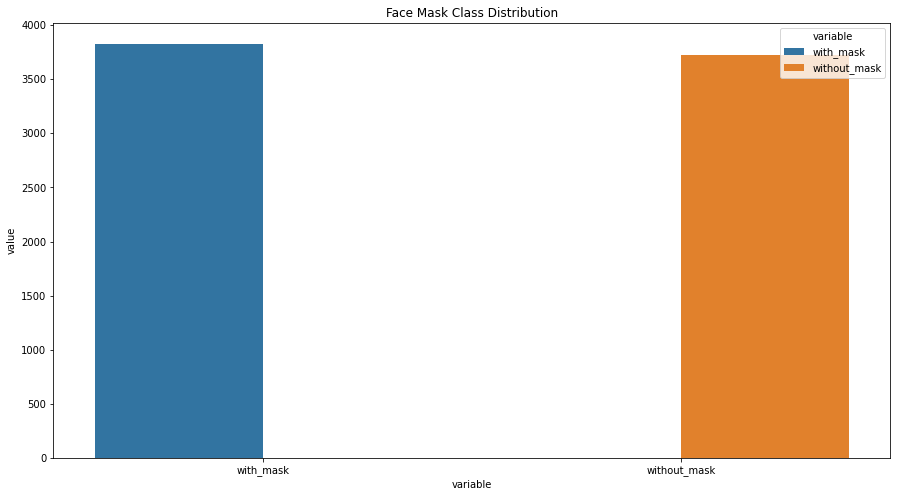

In [13]:
plt.figure(figsize=(15,8))
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(dataset)]).melt(), x = "variable", y="value", hue="variable").set_title('Face Mask Class Distribution')
plt.show()

In [ ]:
len(dataset)

In [ ]:
train_dataset, val_dataset = random_split(dataset, (6000, 1553))

In [ ]:
train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=32, num_workers=5)
val_loader = DataLoader(dataset=val_dataset, shuffle=False, batch_size=32, num_workers=5)
print("Length of the train_loader:", len(train_loader))
print("Length of the val_loader:", len(val_loader))

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
classes = ('with_mask', 'without_mask')
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv = nn.Sequential(

            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),    
            nn.BatchNorm2d(32),                                      
            nn.ReLU(),                                               
                                                 
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),   
            nn.BatchNorm2d(64),                                      
            nn.ReLU(),                                               
            nn.MaxPool2d(2),                                         
            
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  
            nn.BatchNorm2d(128),                                     
            nn.ReLU(),                                                                                      
            
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(128),                                     
            nn.ReLU(),                                               
            nn.MaxPool2d(2),                                         

        )
        
        self.fc1 = torch.nn.Linear(6272, 512)
        self.fc2 = torch.nn.Linear(512,2)
    
    def forward(self, x):
#         print("함수들어가기 전", x.shape)
        x = self.conv(x)
#         print("모든layer거친 후", x.shape)
        x = x.view(x.shape[0], -1)
#         print("Flatten", x.shape)
        x = F.relu(self.fc1(x))
#         print("relu(fc1)", x.shape)
        x = self.fc2(x)
#         print("fc2출력", x.shape)
        return x

net = Net()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
def images_to_probs(net, images):
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

def evaluate(net, dataloader):
    correct, total = 0, 0
    with torch.no_grad():
        net.eval()
        for images, labels in dataloader:
            images, labels = images, labels.numpy()

            preds, probs = images_to_probs(net, images)

            total += len(labels)
            correct += (preds == labels).sum()
    return correct/total * 100

from tqdm.notebook import tqdm

def train(net, loss_fn, opt, dataloader, epochs):
    num_steps = 0
    min_loss = 1e+10

    for epoch in tqdm(range(1, epochs+1), total=epochs, desc='Training'):
        running_loss = []
        net.train() # Setting the network to TRAIN mode
        for images, labels in dataloader:
            images, labels = images, labels
            num_steps += 1

            # FP
            outs = net(images)
            loss = loss_fn(outs, labels)

            # Logging the loss value
            running_loss.append(loss.item())

            # BP
            opt.zero_grad()
            loss.backward()
            opt.step()

            # Clearing the RAM
            #del images, labels, outs
            #torch.device('cpu').empty_cache()
        
        epoch_loss = sum(running_loss) / len(running_loss)
        acc = evaluate(net, dataloader)
        print("Accuracy: ",acc)
        print("loss: ",epoch_loss)
        # Model Checkpointing
        if epoch_loss < min_loss:
            min_loss = epoch_loss
            bestmodel = net.state_dict()
    #torch.save(bestmodel,'{0}_{1:0.4f}.pth'.format('classifier',min_loss))
    return None

    print('Training finished!!!')

In [ ]:
train(net, criterion, optimizer, train_loader, 5)

In [ ]:
testimg, testlab = next(iter(val_loader))
testimg, testlab = testimg, testlab

pred = net(testimg)
predlab = torch.argmax(pred,axis=1)

In [ ]:
print("Predicted",[i for i in predlab])
print("Actual",[i for i in testlab])
for i in predlab:
  if i == 0:
    print("without_mask")
  else:
    print("with_mask")
print("______________________________________________________________________________________________________________")
for i in testlab:
  if i == 0:
    print("without_mask")
  else:
    print("with_mask")

In [ ]:
predlab = predlab.to(torch.device('cpu'))
testlab = testlab.to(torch.device('cpu'))
pred = predlab.numpy()
test = testlab.numpy()
matrix = confusion_matrix(test,pred)
print(matrix)

In [ ]:
report = classification_report(test, pred, target_names=['with_mask','without_mask'])
print(report)  

In [ ]:
import cv2

labels_dict={0:'without_mask',1:'with_mask'}
color_dict={0:(0,0,255),1:(0,255,0)}

size = 4
webcam = cv2.VideoCapture(0) #Use camera 0

# We load the xml file
classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

while True:
    (rval, im) = webcam.read()
    im=cv2.flip(im,1,1) #Flip to act as a mirror

    # Resize the image to speed up detection
    mini = cv2.resize(im, (im.shape[1] // size, im.shape[0] // size))

    # detect MultiScale / faces 
    faces = classifier.detectMultiScale(mini)

    # Draw rectangles around each face
    for f in faces:
        (x, y, w, h) = [v * size for v in f] #Scale the shapesize backup
        #Save just the rectangle faces in SubRecFaces
        face_img = im[y:y+h, x:x+w]
        resized=cv2.resize(face_img,(224,224))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,3,224,224))
#         reshaped = np.vstack([reshaped])
        result=net.forward(torch.FloatTensor(reshaped))
#         print(result)
        
        label=torch.argmax(result,dim=1)[0]
        label = label.tolist()
#         print(label)
    
        cv2.rectangle(im,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(im,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(im, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
    # Show the image
    cv2.imshow('LIVE',   im)
    key = cv2.waitKey(30)
    # if Esc key is press then break out of the loop 
    if key == 27: #The Esc key
        break